In [2]:
# using Images, TestImages, ImageIO, ImageMagick, ImageView, Colors
# using StatsBase, Statistics, LinearAlgebra, Plots, Random
# using Flux
using Plots, Images, Random
using Flux

In [7]:
VERSION

v"1.11.1"

In [8]:
import Pkg
Pkg.status("Flux")
VERSION

Status `~/.julia/environments/v1.11/Project.toml`
⌃ [587475ba] Flux v0.14.21
Info Packages marked with ⌃ have new versions available and may be upgradable.


v"1.11.1"

In [9]:
const NN = 10

10

In [10]:

function noisy_square() #make a 'noisy' square image
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( (rr >= 3 && rr <= 7) && (cc >= 3 && cc <= 7) )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

function noisy_cross() #function 'noisy cross' image generator
    newPic = ones(NN,NN)
    for rr = 1:NN
        for cc = 1:NN
            if( rr == 5 || cc == 5 )
                if( rand() >= 0.1 ) newPic[rr,cc] = 0 end
            end
        end
    end
    return newPic
end

noisy_cross (generic function with 1 method)

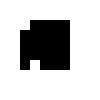

In [11]:
Gray.( noisy_square() ) #make a sample noisy square

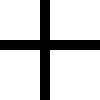

In [12]:
Gray.( noisy_cross() ) #make a sample cross

In [13]:
const img_Num = 100 #number of images of each type to generate

100

In [14]:
squares = [vec(noisy_square()) for i in 1:img_Num];
crosses = [vec(noisy_cross()) for i in 1:img_Num];

In [15]:
Gray.(squares[1])

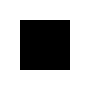

In [16]:
reshape( Gray.(squares[1]) , NN , NN )

In [17]:
real_data = vcat( squares , crosses ); #real data examples

(100, 200)

(10, 10, 200)

(10, 10, 1, 200)

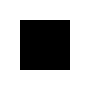

In [18]:
#data must be in WxHxCxN but for generator it is 1 d entry so that is WxHxCxN we reshape
tmp = Flux.stack( real_data , dims=2 )
display( size( tmp ) )
tmp = reshape( tmp , (10,10,200) )
display( size( tmp ) )
real_data_WHCN = Flux.unsqueeze( tmp , dims = 3 ) # WHCN format as needed
display( size( real_data_WHCN ) )
Gray.( real_data_WHCN[ : , : , 1 , 1 ] )

In [19]:
real_data_labels = Int.([ ones( 100 ) ; 2*ones(100) ]); #the labels associated with the real data
display( size(real_data_labels) )
display( real_data_labels[ 1 ] )
display( real_data_labels[ end ] )

(200,)

1

2

In [21]:
const latent_dim = 10

10

In [22]:
function make_z_vectors_conditional( labels ) #make z samples with the label information concatenated
    z = rand( latent_dim , length(labels) )
    z_label = repeat( labels' , latent_dim , 1 )
    return cat( z_label , z , dims=1 ) #joint representation of the embedding of the label and noise vector z
end

make_z_vectors_conditional (generic function with 1 method)

In [23]:
make_z_vectors_conditional( [1,2,1] ) #look at the representation of latent z and the label information

20×3 Matrix{Float64}:
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 1.0        2.0        1.0
 0.153575   0.396417   0.91123
 0.65421    0.815425   0.956594
 0.801642   0.0738148  0.135138
 0.725174   0.778667   0.512051
 0.0100925  0.638038   0.232345
 0.637959   0.704104   0.960416
 0.51152    0.0159332  0.55121
 0.345376   0.91107    0.487123
 0.327767   0.0999725  0.675642
 0.847672   0.462305   0.52273

In [24]:
generator = Chain( 
      Dense( 2*latent_dim => 100 ) ,
      BatchNorm( 100 , relu ) ,
      x->reshape( x , 5 , 5 , 4 , : ) , #make into WHCN
      ConvTranspose( (4,4) , 4 => 2 ; stride = 1, pad = 1 ) ,
      BatchNorm( 2 , relu ) ,
      ConvTranspose( (5,5) , 2 => 1 ; stride = 1, pad = 1 ) ,
      ConvTranspose( (5,5) , 1 => 1 ; stride = 1, pad = 1 ) ,
      sigmoid
    );

In [25]:
generator( make_z_vectors_conditional( [2] ) )

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(20 => 100)
│   summary(x) = 20×1 Matrix{Float64}
└ @ Flux /home/meow/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60


10×10×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.502389  0.499043  0.502974  0.496619  …  0.513993  0.509233  0.505197
 0.529131  0.523754  0.467976  0.473509     0.504989  0.484513  0.49657
 0.492905  0.530571  0.499758  0.497923     0.494591  0.504515  0.48749
 0.460541  0.469062  0.559131  0.584826     0.468502  0.537783  0.510571
 0.504194  0.433886  0.552307  0.544023     0.513012  0.484937  0.501276
 0.518569  0.590323  0.493048  0.453211  …  0.510895  0.472899  0.47536
 0.471038  0.522739  0.508875  0.489603     0.467919  0.517675  0.498679
 0.489364  0.42026   0.454312  0.504516     0.434346  0.505652  0.518357
 0.541383  0.47435   0.454434  0.524935     0.524553  0.515953  0.495182
 0.514655  0.552644  0.520515  0.455213     0.523068  0.514757  0.501339

(10, 10, 1, 4)

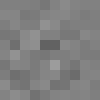

In [26]:
display( size( generator( make_z_vectors_conditional( [1,2,2,1] ) ) ) )
Gray.( generator(make_z_vectors_conditional([2]))[:,:,1,1] )

In [27]:
discriminator = Chain( #discriminator takes in 2 channel data, the pixel info in 1 and the label info on the next
      Conv( (4,4) , 2 => 2 , stride = 1 , pad = 1 ) ,
      relu ,
      Conv( (4,4) , 2 => 1 , stride = 1 , pad = 1 ) ,
      relu ,
      Flux.flatten ,
      Dense( 64 => 10 , relu ) ,
      Dense( 10 => 1 ) ,
      sigmoid
    );

In [28]:
embedding_model = Chain( Embedding( 2=>NN*NN ), x->reshape(x,10,10,1,size(x,2)) );#2 class embedding -> number of pixels

In [29]:
embedding_model([1]) #see the embedding of the label information

10×10×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  1.00608    1.07436     -1.45432    …  -0.011936   0.230754    -0.416071
  0.615002   0.16164      1.82675       -0.872222  -1.27561     -0.496986
  0.234718  -0.117242    -0.528029      -1.29348    0.303926    -0.685429
  0.510997   0.851637    -1.32515       -1.13945    0.00277902  -0.666767
 -0.243905   1.54704      0.274112       0.620947   0.544706    -0.674833
 -0.220335   0.374798    -0.0256392  …   0.250303   0.242414    -1.07579
  0.398274   0.00144143  -0.422589       0.11311   -1.42266     -0.613972
 -0.594671  -1.36634      0.184756       0.111027  -0.348472    -0.996427
 -0.52941    0.411913    -0.428925       0.69653    0.887311     0.58985
 -0.378235  -0.144485    -1.45323        2.03942    0.405312    -2.10819

In [30]:
cat( generator(make_z_vectors_conditional([2])) , embedding_model([1]) , dims=3 ) #do the channel data augmentation

10×10×2×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.502781  0.499536  0.501374  0.495537  …  0.517025  0.511354  0.50483
 0.526332  0.527566  0.471887  0.473171     0.508432  0.484876  0.494924
 0.493015  0.529883  0.498132  0.502737     0.499666  0.501105  0.487
 0.466207  0.463767  0.550775  0.584734     0.469655  0.535413  0.510465
 0.50502   0.435912  0.545391  0.551851     0.514872  0.488163  0.499669
 0.515192  0.583203  0.496585  0.472831  …  0.520586  0.474324  0.477786
 0.471001  0.519293  0.512855  0.496449     0.47793   0.511876  0.500678
 0.488525  0.43023   0.459118  0.502442     0.439401  0.502487  0.516605
 0.540789  0.476516  0.460076  0.509959     0.514496  0.51552   0.491242
 0.517153  0.548335  0.513941  0.451546     0.513221  0.513305  0.500352

[:, :, 2, 1] =
  1.00608    1.07436     -1.45432    …  -0.011936   0.230754    -0.416071
  0.615002   0.16164      1.82675       -0.872222  -1.27561     -0.496986
  0.234718  -0.117242    -0.528029      -1.29348    0.303926    -0

In [31]:
labels_tmp = [1,2,2,1]
display( size( cat( generator( make_z_vectors_conditional(labels_tmp)) , embedding_model(labels_tmp) , dims=3 ) ) )
discriminator( cat( generator( make_z_vectors_conditional(labels_tmp)) , embedding_model(labels_tmp) , dims=3 ) ) 

(10, 10, 2, 4)

1×4 Matrix{Float32}:
 0.510972  0.546888  0.54521  0.510921

In [32]:
inds_tmp = [1,50,150,200]
labels_tmp = real_data_labels[ inds_tmp ]
discriminator( cat( real_data_WHCN[:,:,:,inds_tmp] , embedding_model(labels_tmp) , dims=3 ) ) #feeding real data

1×4 Matrix{Float32}:
 0.464152  0.457144  0.461497  0.451483

In [34]:
function generator_loss( fake_output ) 
    Flux.binarycrossentropy( fake_output , 1 )
end

function discriminator_loss( real_output , fake_output )
    real_loss = Flux.binarycrossentropy( real_output , 1 )
    fake_loss = Flux.binarycrossentropy( fake_output , 0 )
    return real_loss + fake_loss
end

discriminator_loss (generic function with 1 method)

In [35]:
function train_generator( generator , discriminator , embedding , generator_optimizer , labels )
    loss, grads = Flux.withgradient( generator ) do generator
        images_tmp = generator( make_z_vectors_conditional(labels) )
        discriminator_output = discriminator( cat( images_tmp , embedding(labels) , dims=3 ) )
        generator_loss( discriminator_output )        
    end
    Flux.update!( generator_optimizer , generator , grads[1] )
    return loss
end

train_generator (generic function with 1 method)

In [36]:
function train_discriminator( generator , discriminator , embedding , data , discrimator_optimizer , embedding_optimizer , labels )
    
    loss, grads = Flux.withgradient(discriminator,embedding) do discriminator,embedding #train the discriminator and embedding
        images_tmp = generator( make_z_vectors_conditional(labels) )
        generator_output = cat( images_tmp , embedding(labels) , dims=3 )
        real_output = cat( data , embedding(labels) , dims=3 )
        discriminator_loss( discriminator( real_output ) , discriminator( generator_output ) )
    end
    Flux.update!( (discrimator_optimizer,embedding_optimizer) , (discriminator,embedding) , grads ) #update parameters of both disc and emb
    return loss
end

train_discriminator (generic function with 1 method)

In [37]:
discrimator_optimizer = Flux.setup( Adam( 0.0002 ) , discriminator );
generator_optimizer = Flux.setup( Adam( 0.0002 ) , generator );
embedding_optimizer = Flux.setup( Adam( 0.0002 ) , embedding_model );

In [38]:
display( train_discriminator( generator , discriminator , embedding_model , real_data_WHCN[:,:,:,1:2] , discrimator_optimizer , embedding_optimizer , [1,1] ) )
display( train_generator( generator , discriminator , embedding_model , generator_optimizer , [1,2] ) )

1.4921243f0

0.66235554f0

In [39]:
loss_dis_array = []
loss_gen_array = []

Any[]

In [40]:
batch_num = 10

for epoch in 1:100_000
    
    tmp_inds = Random.randperm(length(real_data_labels))[1:batch_num]
    labels_tmp = real_data_labels[ tmp_inds ]
    
    x_real_tmp = real_data_WHCN[:,:,:,tmp_inds]
            
    loss_dis = train_discriminator( generator , discriminator , embedding_model , x_real_tmp , discrimator_optimizer , embedding_optimizer , labels_tmp )
    push!( loss_dis_array , loss_dis )
    
    loss_gen = train_generator( generator , discriminator , embedding_model , generator_optimizer , labels_tmp )
    push!( loss_gen_array , loss_gen )
    
end

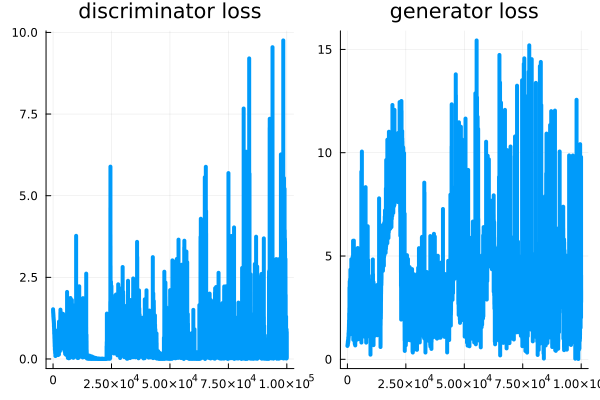

In [51]:
p_dis = plot( loss_dis_array , title="discriminator loss" , legend = false, linewidth=4)
p_gen = plot( loss_gen_array , title="generator loss" , legend = false, linewidth=4 )
p = plot( p_dis , p_gen , fmt = :png)
savefig( p , "lossesConditional.png" )
display( p )

In [52]:
inds_tmp = [1,50,150,200]
labels_tmp = real_data_labels[ inds_tmp ]
discriminator( cat( real_data_WHCN[:,:,:,inds_tmp] , embedding_model(labels_tmp) , dims=3 ) ) #feeding real data

1×4 Matrix{Float32}:
 0.990495  0.985242  1.0  0.999998

In [53]:
labels_tmp = [1,2,1,2]
display( discriminator( cat( generator( make_z_vectors_conditional(labels_tmp)) , embedding_model(labels_tmp) , dims=3 ) ) ) #check discriminator output

1×4 Matrix{Float32}:
 0.0454143  0.0279865  0.046067  0.0279566

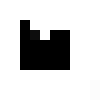

In [54]:
generated_image = Gray.(generator( make_z_vectors_conditional(labels_tmp))[:,:,1,1])

p = Gray.( generated_image[:,:,1,1] )
save( "generatorCGAN1.png", p )
display( p )

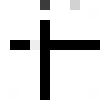

In [55]:
generated_image = Gray.(generator( make_z_vectors_conditional(labels_tmp))[:,:,1,2])
p = Gray.( generated_image[:,:,1,1] )
save( "generatorCGAN2.png", p )
display( p )

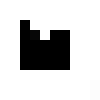

In [56]:
Gray.(generator( make_z_vectors_conditional(labels_tmp))[:,:,1,3])

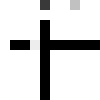

In [57]:
Gray.(generator( make_z_vectors_conditional(labels_tmp))[:,:,1,4])

In [49]:
embedding_model([1]) #see the embedding of the label information

10×10×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
  1.63005    0.661019  -1.84759    …   0.141977   -0.53812    -0.678198
  0.601007   0.469467   2.04251       -1.49038    -1.26573    -0.767991
  0.398685  -0.029665  -0.647364      -1.11255     0.600065   -0.414299
  0.671884   1.66588   -1.13282       -1.60746     0.292949   -0.0844748
 -0.257732   1.15714    0.642035      -0.0784878   1.33973    -0.618865
  0.158652   0.29588   -0.192727   …   0.831057   -0.106017   -0.948922
  0.561507   0.168999  -1.21419        0.0483463  -0.820785   -1.06426
 -0.403209  -1.25368    0.206607       0.53569    -0.615998   -0.935126
 -0.514791   1.39966    0.0462852      1.0378      1.62204     0.761942
 -0.821998  -0.708803  -1.43098        1.71912    -0.0318099  -2.2171

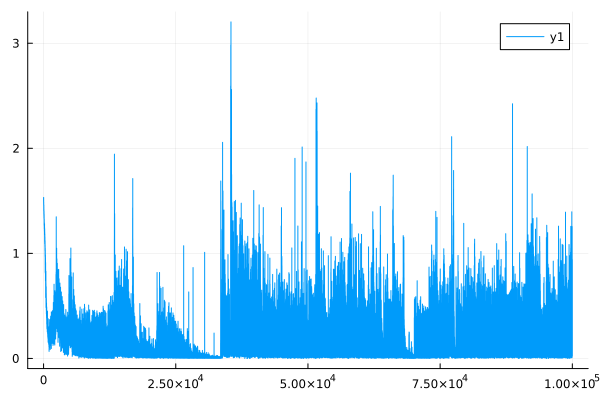